In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import transforms as tfs
from torchvision.datasets import MNIST

from PIL import Image

# MNIST RECOGNIZER

In [84]:
data_tfs = tfs.Compose([
    tfs.Resize((28, 28)),
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

root = './'
train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
valid_dataset = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=6,
                             shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=19,
                             shuffle=False, num_workers=4)


(28, 28)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


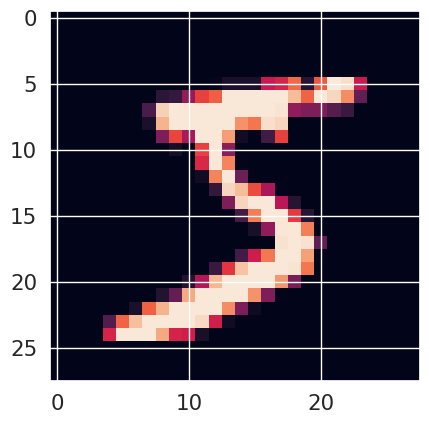

In [73]:
numpy_img = train_dataloader.dataset.train_data[0].numpy()
print(numpy_img.shape)
plt.imshow(numpy_img)

In [5]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

In [6]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {'train': train_dataloader,
           'valid': valid_dataloader}

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

'cpu'

In [8]:
max_epochs = 50
accuracy = {'train': [],
            'valid': []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == 'train':
                model.train()
                optimizer.zero_grad()
                output = model(x_batch)
                loss = loss_func(output, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    output = model(x_batch)
                    
            predictions = output.argmax(-1)
            correct = len([pred for i,
                          pred in enumerate(predictions) if pred == y_batch[i]])
            _all = y_batch.shape[0]
            epoch_correct += correct
            epoch_all += _all
        if k == 'train':
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9102833333333333
Loader: valid. Accuracy: 0.9548
Epoch: 2
Loader: train. Accuracy: 0.9510833333333333
Loader: valid. Accuracy: 0.9505
Epoch: 3
Loader: train. Accuracy: 0.9599
Loader: valid. Accuracy: 0.9689
Epoch: 4
Loader: train. Accuracy: 0.9644333333333334
Loader: valid. Accuracy: 0.9638
Epoch: 5
Loader: train. Accuracy: 0.96845
Loader: valid. Accuracy: 0.9636
Epoch: 6
Loader: train. Accuracy: 0.97055
Loader: valid. Accuracy: 0.9646
Epoch: 7
Loader: train. Accuracy: 0.9723833333333334
Loader: valid. Accuracy: 0.9648
Epoch: 8
Loader: train. Accuracy: 0.9738166666666667
Loader: valid. Accuracy: 0.9707
Epoch: 9
Loader: train. Accuracy: 0.9740666666666666
Loader: valid. Accuracy: 0.9704
Epoch: 10
Loader: train. Accuracy: 0.97595
Loader: valid. Accuracy: 0.9624
Epoch: 11
Loader: train. Accuracy: 0.9770833333333333
Loader: valid. Accuracy: 0.9728
Epoch: 12
Loader: train. Accuracy: 0.9779333333333333
Loader: valid. Accuracy: 0.9671
Epoch: 13
Loader: trai

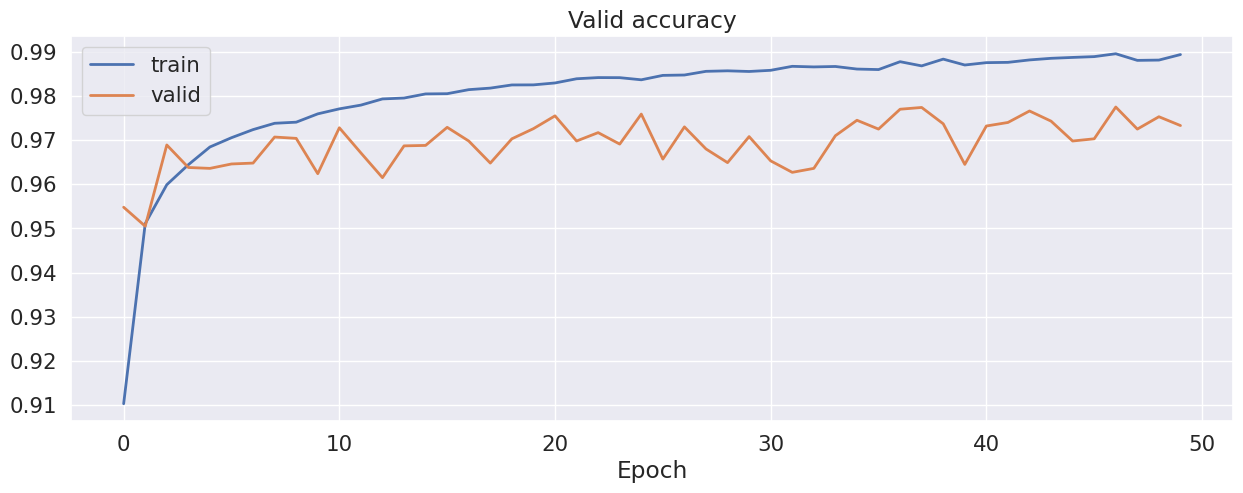

In [10]:
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

plt.figure(figsize=(15, 5))
plt.plot(range(max_epochs), accuracy['train'], label='train', linewidth=2)
plt.plot(range(max_epochs), accuracy['valid'], label='valid', linewidth=2)
plt.title('Valid accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [11]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [12]:
# torch.save(model, '/kaggle/working/MNIST_model.pt')

<class 'torch.Tensor'> torch.Size([19, 1, 28, 28])
<class 'torch.Tensor'>


,0
Ground Truth,7
Predicted label,7


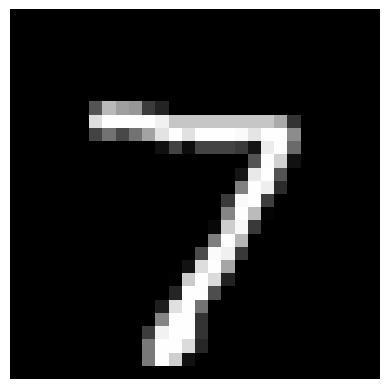

In [85]:
dataiter = iter(valid_dataloader)
images, labels = next(dataiter)
print(type(images), images.shape)
image = images[0]
print(type(image))
outputs = model(image)
_, predicted = torch.max(outputs, 1)
n_test = 1
df_result = pd.DataFrame({
    'Ground Truth': labels[:n_test],
    'Predicted label': predicted[:n_test]})
display(df_result.T)
imshow(torchvision.utils.make_grid(images[:n_test, :, :, :], nrow=n_test))

In [ ]:
# from PIL import Image, ImageFilter


# def imageprepare(argv):
#     """
#     This function returns the pixel values.
#     The imput is a png file location.
#     """
#     im = Image.open(argv).convert('L')
#     width = float(im.size[0])
#     height = float(im.size[1])
#     newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

#     if width > height:  # check which dimension is bigger
#         # Width is bigger. Width becomes 20 pixels.
#         nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
#         if (nheight == 0):  # rare case but minimum is 1 pixel
#             nheight = 1
#             # resize and sharpen
#         img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
#         wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
#         newImage.paste(img, (4, wtop))  # paste resized image on white canvas
#     else:
#         # Height is bigger. Heigth becomes 20 pixels.
#         nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
#         if (nwidth == 0):  # rare case but minimum is 1 pixel
#             nwidth = 1
#             # resize and sharpen
#         img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
#         wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
#         newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

#     newImage.save("sample.png")

#     tv = list(newImage.getdata())  # get pixel values

#     # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
#     tva = [(255 - x) * 1.0 / 255.0 for x in tv]
#     print(tva)
#     return tva

# x = imageprepare('/kaggle/input/minst-example/unnamed.png')#file path here
# print(x)# mnist IMAGES are 28x28=784 pixels

,0
Ground Truth,5
Predicted label,0


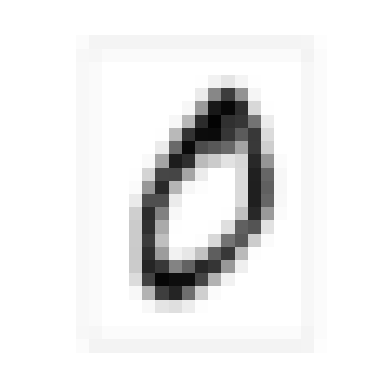

In [94]:
mnist_example = Image.open(fp='/kaggle/input/minst-example/FK0FB.png')
mnist_example_tfs = data_tfs(mnist_example)
output_example = model(mnist_example_tfs)
_, predicted_example = torch.max(output_example, 1)
n_test = 1
df_result = pd.DataFrame({
    'Ground Truth': 5,
    'Predicted label': predicted_example[:n_test]})
display(df_result.T)
imshow(mnist_example_tfs)